In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import Imputer, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression

DATASET_PATH = os.path.join(os.getcwd(), 'datasets')

# Grab the data
The competition supplies separate CSVs for the training (1460 instances) and test (1459 instances) sets. We're assuming there is stratified sampling. The CSVs have been downloaded into the working directory on my local machine.

In [2]:
def load_data(dataset_path=DATASET_PATH):
    with open(os.path.join(DATASET_PATH, 'test.csv')) as test, open(os.path.join(DATASET_PATH, 'train.csv')) as train:
        return pd.read_csv(test), pd.read_csv(train)

In [3]:
test_df, train_df = load_data()
test_df.set_index('Id', inplace=True)
train_df.set_index('Id', inplace=True)

# EDA
Exploring the training dataset

In [4]:
# Each row represents one house.  There are 79 features and 1460 instances
# The 'SalePrice' column contains the value that we'll be predicting for each house in the test set
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# We see that there are many features with null values -- we'll have to take care of this later
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [6]:
# SalePrice mean is ~$180k with STD $79k. It seems that saleprice values are quite dispersed
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

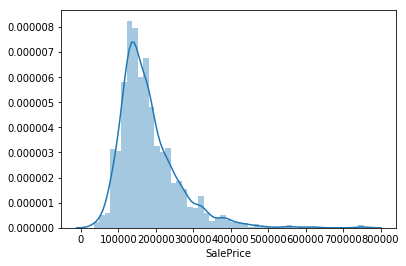

In [7]:
sns.distplot(train_df['SalePrice'])
# Housing sale prices are distributed around ~150k, skewed left with < 10 instances selling above $500k.

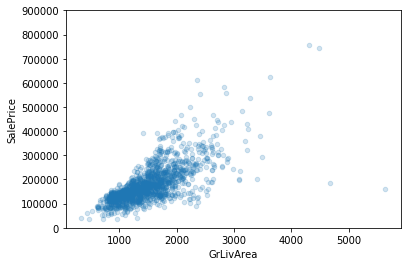

In [8]:
train_df.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.2, ylim=(0,900000))
# It seems that the the above-ground square footage variable positively correlates with the price of the house

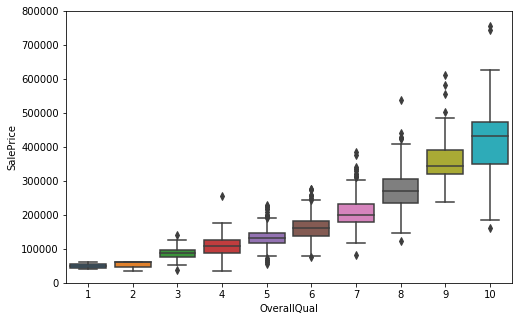

In [9]:
f, ax = plt.subplots(figsize=(8, 5))
fig = sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
fig.axis(ymin=0, ymax=800000);
# It also seems that the the overall quality variable positively correlates with the price of the house
# However, we really don't know how this 'quality' metric is calculated

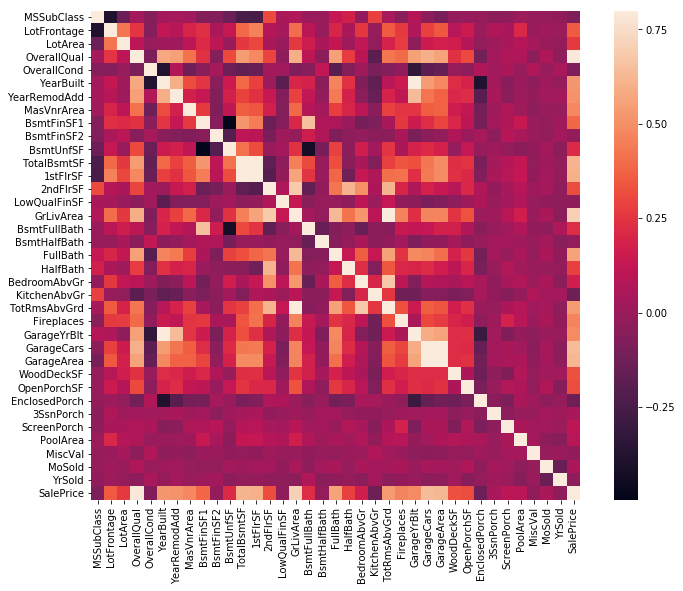

In [10]:
# plotting correlation matrix; the bottom row depicts the SalesPrice correlation with all other features
corr_matrix = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=.8, square=True);

In [11]:
# From this, we see the features that correlate with SalePrice most strongly
corr_matrix['SalePrice'].sort_values(ascending=False)[1:10]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

# Cleaning the Data

In [12]:
# Separate the independent and dependent variables (labels), preparing for training
housing = train_df.drop('SalePrice', axis=1)
housing_labels = train_df['SalePrice'].copy()

In [13]:
# Let's explore the features with missing values
nulls = housing.isnull().sum().sort_values(ascending=False)
pct_null = (housing.isnull().sum() / housing.isnull().count()).sort_values(ascending=False)
nulls_df = pd.concat([nulls, pct_null], axis=1, keys=['total_null', 'pct_null'])

# display top null features, along with their correlation to SalePrice
nulls_df.loc[nulls_df.total_null > 0].reset_index().merge(corr_matrix['SalePrice'].reset_index(), how='left', on='index')

,index,total_null,pct_null,SalePrice
0,PoolQC,1453,0.995205,NaN
1,MiscFeature,1406,0.963014,NaN
2,Alley,1369,0.937671,NaN
3,Fence,1179,0.807534,NaN
4,FireplaceQu,690,0.472603,NaN
5,LotFrontage,259,0.177397,0.351799
6,GarageCond,81,0.055479,NaN
7,GarageType,81,0.055479,NaN
8,GarageYrBlt,81,0.055479,0.486362
9,GarageFinish,81,0.055479,NaN


In [14]:
# Upon examining the features with null values, all do not correlate with SalePrice (not enough data to calculate correlation)
# We will drop them with the custom transformer that is constructed below

def drop_mostly_null_features(X, drop_nulls=True):
    if drop_nulls:
        # dropping columns with more than one null value
        nulls = X.isnull().sum().sort_values(ascending=False)
        pct_null = (X.isnull().sum() / X.isnull().count()).sort_values(ascending=False)
        nulls_df = pd.concat([nulls, pct_null], axis=1, keys=['total_null', 'pct_null'])
        
        X = X.drop((nulls_df[nulls_df.total_null > 1]).index, 1)

        # dropping the single row where 'Electrical' is null
        X = X.drop(X.loc[housing.Electrical.isnull()].index)
        return X
    else:
        return X

null_dropper = FunctionTransformer(drop_mostly_null_features, validate=False, kw_args={"drop_nulls": False})
housing_trimmed =  null_dropper.fit_transform(housing)

In [15]:
# Separate out the features that are categorical (non-numeric) so that we can transform them to dummy variables
housing_cat = housing_trimmed.select_dtypes('object')

# A simple pandas method for a OneHotEncoder
housing_cat = pd.get_dummies(housing_cat).reset_index().drop('Id', axis=1)

In [16]:
# We'll now need to do some feature scaling on the numerical data. Scikit-learn has us covered with StandardScaler

housing_num = housing_trimmed.select_dtypes('int')
std_scaler = StandardScaler()
housing_num_scaled = pd.DataFrame(std_scaler.fit_transform(housing_num), columns=housing_num.columns)

In [17]:
# Combine the numeric and categorical data, display the top 10 rows. Check to make sure nothing looks wrong
housing_training_prepared = pd.concat([housing_num_scaled, housing_cat], axis=1)
housing_training_prepared.head(10)

# Training Model

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(housing_training_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
lin_reg.predict(housing_training_prepared[:10])

array([208932.5, 205980.5, 207160.5, 166136.5, 293232.5, 147536.5,
       280496.5, 222043.5, 137767.5, 121141.5])